<a href="https://colab.research.google.com/github/bori00/BreastCancerSegmentation/blob/main/Breast_Cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

* Dataset: https://github.com/PathologyDataScience/BCSS
* Paper: https://academic.oup.com/bioinformatics/article/35/18/3461/5307750

# Setup: Importing the libraries and the dataset

In [81]:
import tensorflow as tf

import urllib
from urllib import request

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

import cv2
import os

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading Images and Masks, Create Dataset

In [133]:
TEST_RATIO = 0.2
SEED = 123
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 32
MAX_DATASET_SIZE = 5

In [5]:
IMAGES_DIRECTORY = '/content/rgbs_colorNormalized';
MASKS_DIRECTORY = '/content/masks'

In [6]:
!unzip gdrive/My\ Drive/PRS_Project/masks-20221122T203004Z-001.zip 
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip

Archive:  gdrive/My Drive/PRS_Project/masks-20221122T203004Z-001.zip
replace masks/TCGA-A7-A26F-DX1_xmin72969_ymin11489_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  gdrive/My Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
replace rgbs_colorNormalized/TCGA-OL-A5RW-DX1_xmin5772_ymin6839_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  gdrive/My Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
replace rgbs_colorNormalized/TCGA-A7-A0DA-DX1_xmin43731_ymin18175_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  gdrive/My Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip
replace rgbs_colorNormalized/TCGA-OL-A5D7-DX1_xmin114443_ymin22490_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
def toInt(image):
    return tf.cast(image, tf.int32)

In [71]:
def opencv_image_to_tensor(img):
  res = tf.convert_to_tensor(img, dtype=tf.int32)
  return res

In [149]:
def load_images_and_masks(images_folder, masks_folder):
    images = []
    masks = []
    dim = (IMG_WIDTH, IMG_HEIGHT)
    for idx, filename in enumerate(os.listdir(images_folder)):
        if idx == MAX_DATASET_SIZE:
          break
        img = cv2.imread(os.path.join(images_folder,filename))
        img = cv2.resize(img, dim)
        mask = cv2.imread(os.path.join(masks_folder, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, dim)
        print("Loaded image {0}: {1}".format(idx, filename))
        if img is not None:
            assert mask is not None
            images.append(img.astype(np.int32))
            masks.append(mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1).astype(np.int32))
    return images, masks

In [150]:
images, masks = load_images_and_masks(IMAGES_DIRECTORY, MASKS_DIRECTORY)

Loaded image 0: TCGA-A2-A3XX-DX1_xmin69942_ymin41560_MPP-0.2500.png
Loaded image 1: TCGA-AQ-A54N-DX1_xmin32440_ymin26558_MPP-0.2500.png
Loaded image 2: TCGA-A2-A0YE-DX1_xmin59206_ymin33505_MPP-0.2500.png
Loaded image 3: TCGA-AR-A0TU-DX1_xmin88352_ymin23098_MPP-0.2500.png
Loaded image 4: TCGA-GI-A2C9-DX1_xmin20882_ymin11843_MPP-0.2500.png


In [151]:
print("Nr of images read: {0}".format(len(images)))

Nr of images read: 5


In [152]:
image = images[0]
mask = masks[0]
print("Image shape: {0}; Mask shape: {1}".format(image.shape, mask.shape))

Image shape: (512, 512, 3); Mask shape: (512, 512, 1)


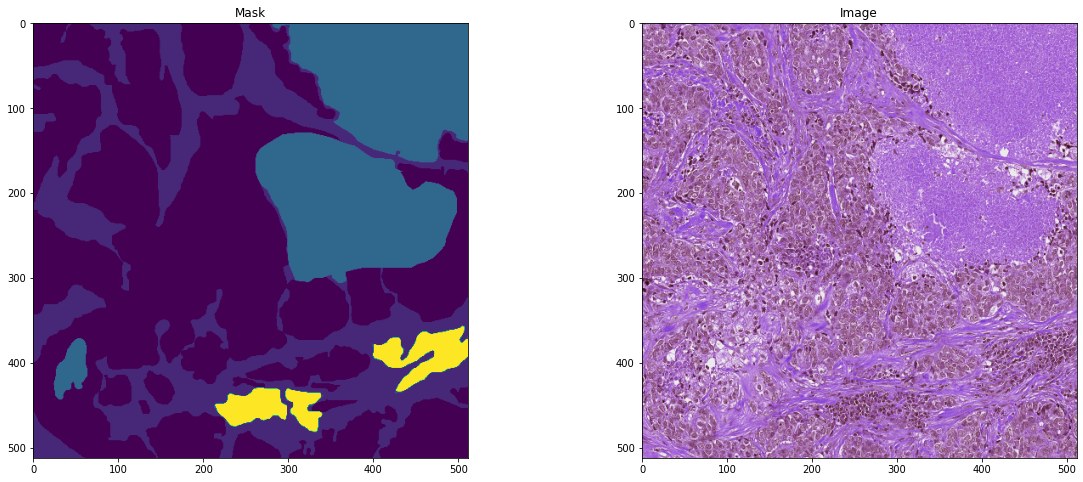

In [153]:
# sample
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(mask.reshape(IMG_HEIGHT, IMG_WIDTH))
plt.title("Mask")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title("Image")

plt.show()

In [154]:
df = pd.DataFrame(data={'images': images,
                        'masks': masks})

In [156]:
data = tf.data.Dataset.from_tensor_slices((images, masks))

In [157]:
print("Total Dataset Size: {0}".format(tf.data.experimental.cardinality(data).numpy()))

Total Dataset Size: 5


In [158]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    # source: https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [159]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data, tf.data.experimental.cardinality(data).numpy())

In [160]:
train_batches = (
    train_ds
    .cache()
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)
test_batches = test_ds.batch(BATCH_SIZE)

## Old Code

In [49]:
# setting dictionary for the tf_data_dataset parameters
tf_Dataset_args=dict(labels=None,
                     label_mode=None,
                     validation_split=TEST_RATIO,
                     batch_size=BATCH_SIZE,
                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                     seed=SEED
                     )

In [ ]:
# train_images_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_DIRECTORY,
#   **tf_Dataset_args,
#   subset="training").map(toInt)

# test_images_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_DIRECTORY,
#   **tf_Dataset_args,
#   subset="validation").map(toInt)

In [ ]:
# train_masks_ds = tf.keras.utils.image_dataset_from_directory(
#   MASKS_DIRECTORY,
#    **tf_Dataset_args,
#   subset="training").map(toInt)

# test_masks_ds = tf.keras.utils.image_dataset_from_directory(
#    MASKS_DIRECTORY,
#    **tf_Dataset_args,
#   subset="validation").map(toInt)

In [ ]:
# train_set=list(zip(train_images_ds, train_masks_ds))

In [ ]:
# test_set=list(zip(test_images_ds, test_masks_ds))

In [ ]:
# training_data = tf.data.Dataset.from_tensor_slices(train_set)
# test_data = tf.data.Dataset.from_tensor_slices(test_set)

## Loading the Class Definitions

In [38]:
classes_df = pd.read_csv("gtruth_codes.csv")
classes_df

,label,GT_code
0,outside_roi,0
1,tumor,1
2,stroma,2
3,lymphocytic_infiltrate,3
4,necrosis_or_debris,4
5,glandular_secretions,5
6,blood,6
7,exclude,7
8,metaplasia_NOS,8
9,fat,9


**Important**: The "outside_roi" class is "don't case", not "others", and should be assigned weight 0 in the model.

# Exploratory Data Analysis

## From the images in the drive folders

In [161]:
def plot_image_and_mask(image_name):
  plt.figure(figsize=(20, 8))
  plt.suptitle("Image: " + image_name)

  plt.subplot(1, 2, 1)
  mask = mpimg.imread(MASKS_DIRECTORY + image_name)
  plt.imshow(mask)
  plt.title("Mask")
  
  plt.subplot(1, 2, 2)
  image = mpimg.imread(IMAGES_DIRECTORY + image_name)
  plt.imshow(image)
  plt.title("Image")

  plt.show()

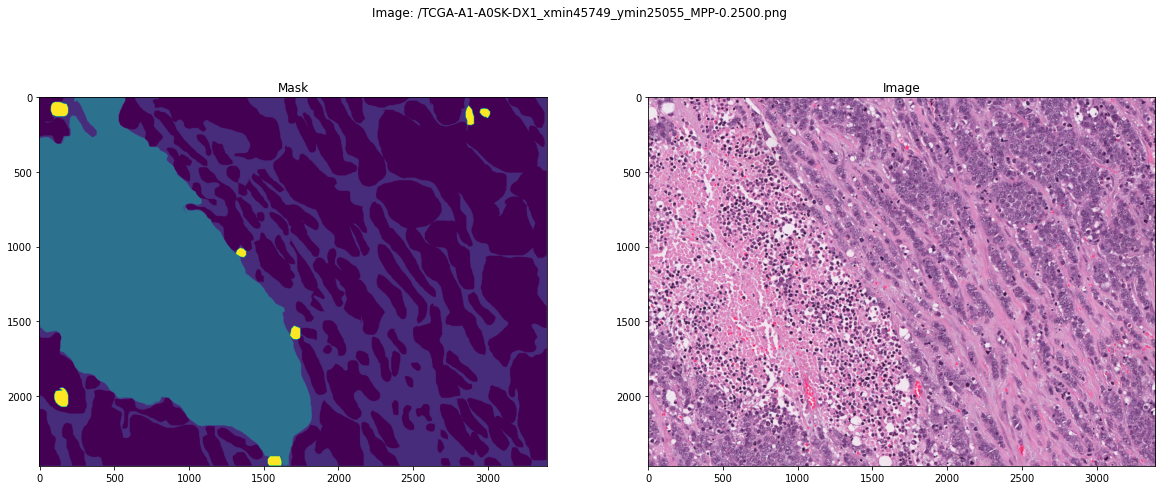

In [40]:
plot_image_and_mask('/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500.png')

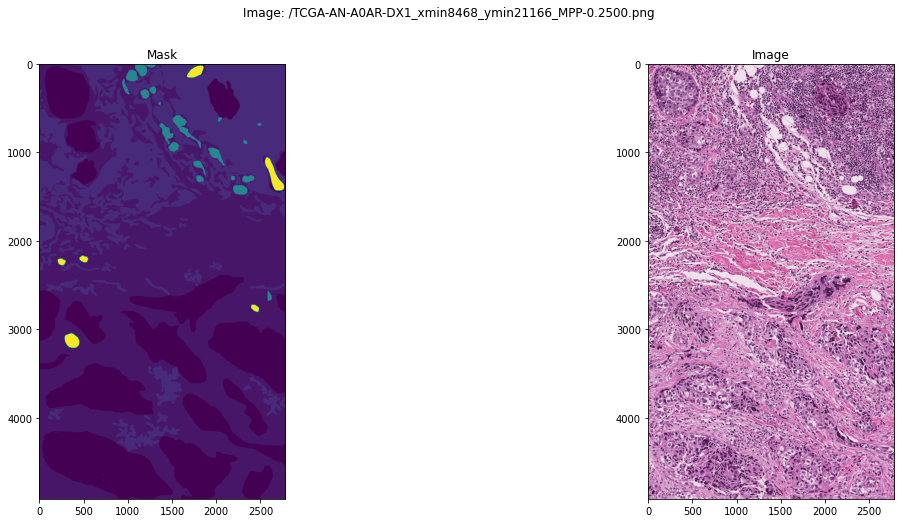

In [41]:
plot_image_and_mask('/TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png')

## From the Dataset

In [162]:
def display(display_list):
  # source: https://www.tensorflow.org/tutorials/images/segmentation
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

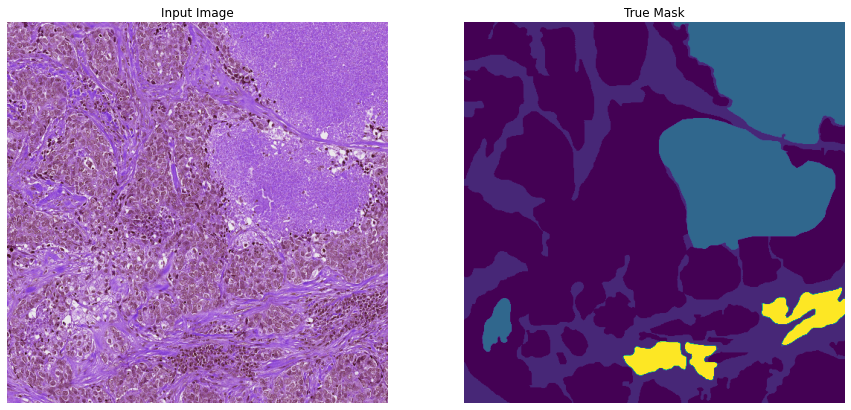

In [164]:
for image, mask in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])